In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.insert(1, 'Trace_Profile')
import TraceModel as tm

In [147]:
import importlib
importlib.reload(tm)

<module 'TraceModel' from 'Trace_Profile/TraceModel.py'>

## Make Order 1 Profile

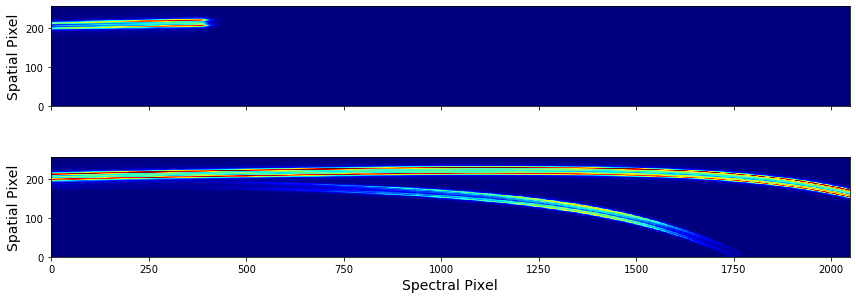

In [2]:
# Open simulated clear and F277W exposures
clear = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/clear.fits')[0].data[::-1, :]
F277 = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/f277.fits')[0].data[::-1, :]

# Visualize the frames
f, ax = plt.subplots(2, sharex=True, figsize=(12, 5))
ax[0].imshow(F277/np.nanmax(F277), origin='lower', cmap='jet')
ax[0].set_ylabel('Spatial Pixel', fontsize=14)

ax[1].imshow(clear/np.nanmax(clear, axis=0), origin='lower', cmap='jet')
ax[1].set_xlabel('Spectral Pixel', fontsize=14)
ax[1].set_ylabel('Spatial Pixel', fontsize=14)

f.tight_layout()

In [3]:
# The end user would really only need to call this one function which
# then completely creates the trace model for them.
# The above examples were just to demonstrate further how the code actually works.
# The trace model can also be written to disk by passing a file name with the 'filename' argument.
tracemodel_wf277 = tm.makemod(clear, F277, do_plots=False)

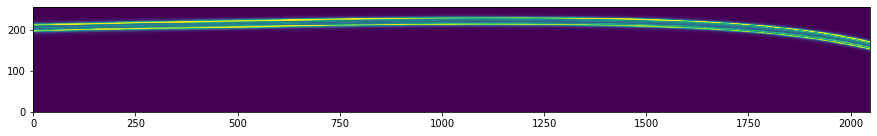

In [4]:
# Visualize the new model.
plt.figure(figsize=(15, 3))
plt.imshow(tracemodel_wf277, origin='lower')

## Extraction

In [5]:
from matplotlib.colors import LogNorm #for better display of FITS images

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel

from overlap import TrpzOverlap
from utils import grid_from_map, get_soss_grid, oversample_grid

In [6]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
T1 = tracemodel_wf277  # fits.open("Ref_files/trace_profile_m1.fits")[0].data.squeeze()
T2 = fits.open("Ref_files/trace_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
T1 = T1.astype(float)
T2 = T2.astype(float)

In [7]:
# Normalised spatial profile
P1 = T1 / T1.sum(axis=0)
P1[np.isnan(P1)] = 0.

P2 = T2 / T2.sum(axis=0)
P2[np.isnan(P2)] = 0.
P2 = P2[::-1, :]

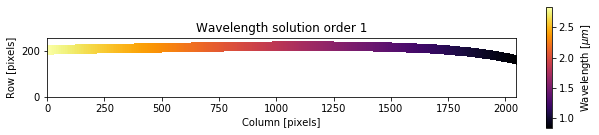

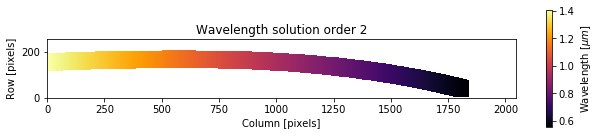

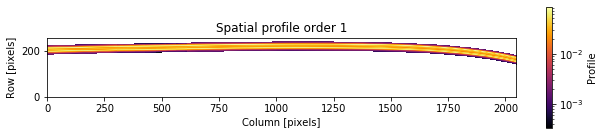

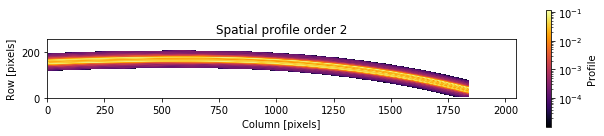

In [8]:
plt.figure(figsize=(9,2))
plt.title("Wavelength solution order 1")
plt.imshow(np.ma.array(wv_1, mask=P1<0.00001), origin='lower')
cmap = plt.colorbar(label="Wavelength [$\mu m$]")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Wavelength solution order 2")
plt.imshow(np.ma.array(wv_2, mask=(P2<0.00001)|(wv_2==0)), origin='lower')
cmap = plt.colorbar(label="Wavelength [$\mu m$]")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Spatial profile order 1")
plt.imshow(np.ma.array(P1, mask=P1<0.00001), norm=LogNorm(), origin='lower')
cmap = plt.colorbar(label="Profile")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("Spatial profile order 2")
plt.imshow(np.ma.array(P2, mask=(P2<0.00001)|(wv_2==0)), norm=LogNorm(), origin='lower')
cmap = plt.colorbar(label="Profile")
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

In [9]:
lam_simu = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=1)
# This basically just gets the wavelength at the trace CoM in each column.
# The second order is preferred in wvelength region where the two overlap due to higher spectral resolution.

In [10]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu_O1 = TrpzOverlap([P1], [wv_1], orders=[0], lam_grid=lam_simu, thresh=1e-11, c_kwargs={'thresh':1e-5})
simu = TrpzOverlap([P1, P2], [wv_1, wv_2], lam_grid=lam_simu, thresh=1e-11, c_kwargs={'thresh':1e-5})
# This is the class that will actually do the extraction by solving the likelihood equation (11 in document)

# ***** WARNING *******
# Since it's oversampled, may take some time to initiate
# (mostly because of the convolution matrix)

create test dataset - inject sinusoid

In [11]:
# Generate flux to inject
flux = 1 + 0.5 * np.sin(lam_simu*500)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
flux *= 1e12
# flux *= 1e9

# Inject (`rebuild` could also take a callable` input.)
scidata = simu.rebuild(flux)
scidata[np.isnan(scidata)] = 0.

scidata_O1 = simu_O1.rebuild(flux, orders=[0])
scidata_O1[np.isnan(scidata_O1)] = 0.
# rebuild just calculates the matrix coefs (b_n, equ 1-3 in document) and multiplies 
# them by the input flux to reconstruct the model detector image.

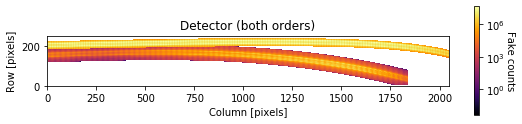

In [12]:
plt.figure(figsize=(9,2))
plt.imshow(scidata, norm=LogNorm(), origin='lower')
cmap = plt.colorbar()
plt.title('Detector (both orders)')
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
cmap.set_label('Fake counts', rotation=270, labelpad=10)

extract first order only

In [134]:
lam_grid = get_soss_grid([P1], [wv_1], n_os=1)

extra = TrpzOverlap([P1], [wv_1], orders=[0], scidata=scidata, lam_grid=lam_grid, thresh=1e-9,
                    c_kwargs={'thresh':0.0001})

IndexError: list index out of range

In [22]:
f_k = extra.extract()
rebuilt = extra.rebuild(f_k)

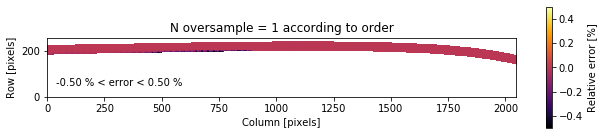

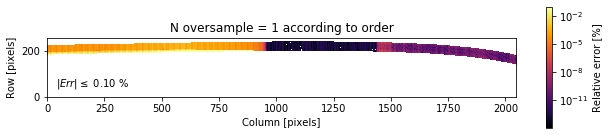

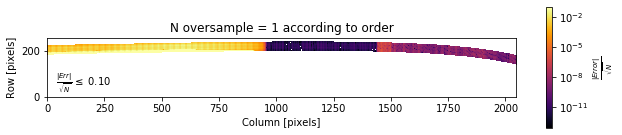

In [23]:
# Look at errors
n_oversample=1
plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow((rebuilt-scidata)/scidata * 100, origin='lower', vmin=-0.5, vmax=0.5)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/scidata * 100, norm=LogNorm(), origin='lower', vmax=1e-1)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm(), origin='lower', vmax=1e-1)
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,46, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

Extract order 2

In [148]:
clear = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/clear.fits')[0].data[::-1, :]
stack = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/InputFiles/CleanStack.fits')[0].data

In [150]:
xOM1, yOM1, tp1 = tm.get_om_centroids(np.arange(2048))
xOM2, yOM2, tp2 = tm.get_om_centroids(np.arange(2048), order=2)

(0, 256)

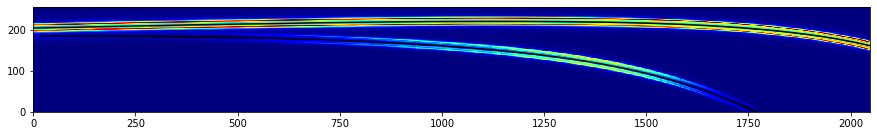

In [156]:
plt.figure(figsize=(15,3))
plt.imshow(clear/np.nanmax(clear, axis=0), origin='lower', cmap='jet')
plt.plot(xOM1, yOM1, c='black')
plt.plot(xOM2, yOM2, c='black')
plt.ylim(0,256)

In [157]:
xCV, yCV = tm.get_data_centroids(stack, np.arange(2048))

In [158]:
AA = tm.do_emcee(xOM1, yOM1, xCV, yCV)

In [159]:
flat_samples = AA.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)

In [160]:
xM1, yM1 = tm.rot_om2det(ang, xanch, yanch, xOM1, yOM1)
xM2, yM2 = tm.rot_om2det(ang, xanch, yanch, xOM2, yOM2, order=2)

(0, 256)

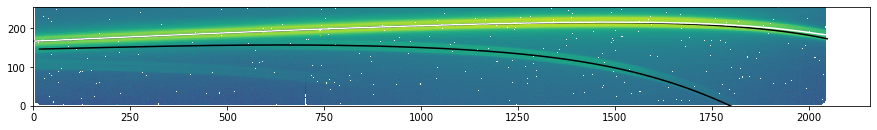

In [164]:
plt.figure(figsize=(15,3))
plt.imshow(np.log10(stack), origin='lower')
plt.plot(xM1, yM1, c='black')
plt.plot(xM2, yM2, c='black')
plt.plot(xCV, yCV, c='white')
plt.ylim(0,256)

In [38]:
AA = clear[0:200, 500:1700]/np.nanmax(clear[0:200, 500:1700], axis=0)
AA[150:, 1000:] = 0
AA = AA / np.nanmax(AA, axis=0)

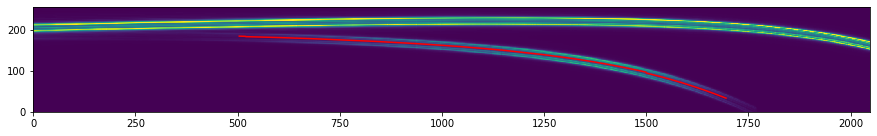

In [110]:
plt.figure(figsize=(15,3))
plt.imshow(clear/np.nanmax(clear, axis=0), origin='lower')
#plt.imshow(AA, origin='lower')
plt.plot(aa[0]+500, aa[1], c='red')
#plt.plot(xOM, yOM, c='blue')

In [39]:
aa = tm.get_data_centroids(AA, atthesex=np.arange(1200))

In [43]:
xOM, yOM, tp2 = get_om_centroids(atthesex=np.linspace(0, 2047, 2048))  # OM

In [82]:
stack = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/InputFiles/CleanStack.fits')[0].data

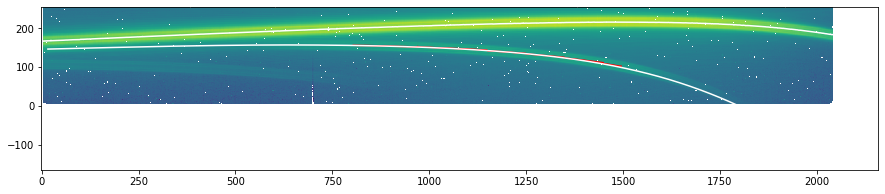

In [145]:
plt.figure(figsize=(15,3))
plt.imshow(np.log10(stack), origin='lower')
plt.plot(ss[0]+800, ss[1], c='red')
#plt.plot(xOM, yOM, c='blue')
plt.plot(EE[0], EE[1], c='white')
plt.plot(CC[0], CC[1], c='white')


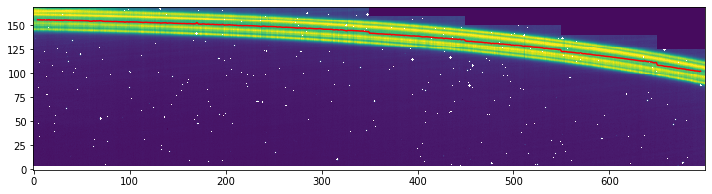

In [79]:
SS = stack[:170,800:1500]
SS[125:,650:] = 0
SS[160:,350:] = 0
SS[150:,450:] = 0
SS[140:,550:] = 0
plt.figure(figsize=(15,3))
plt.imshow(SS/np.nanmax(SS, axis=0), origin='lower')
plt.plot(ss[0], ss[1], c='red')

In [78]:
ss = tm.get_data_centroids(SS, atthesex=np.arange(700))

In [111]:
def log_likelihood(theta, xvals, yvals, xCV, yCV):
    ''' Definition of the log likelihood. Called by do_emcee.
    '''
    ang, orx, ory = theta
    modelx, modely = rot_om2det(ang, orx, ory, xvals, yvals)

    return -0.5 * np.sum(((xCV - modelx[504:1696])**2 + (yCV - modely[504:1696])**2)
                         - 0.5 * np.log(2 * np.pi * 1))


def log_prior(theta):
    ''' Definition of the priors. Called by do_emcee.
    '''
    ang, orx, ory = theta

    if -15 <= ang < 15 and -4048 < orx < 4048 and -456 < ory < 456:
        return -1
    else:
        return -np.inf


def log_probability(theta, xvals, yvals, xCV, yCV):
    ''' Definition of the final probability. Called by do_emcee.
    '''
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, xvals, yvals, xCV, yCV)

In [86]:
def do_emcee(xOM, yOM, xCV, yCV):
    ''' Utility function which calls the emcee package to preform
    an MCMC determination of the best fitting rotation angle/center to
    map the OM onto the data.

    Parameters
    ----------
    xOM, yOM : array of floats
        X and Y trace centroids respectively in the optics model system,
        for example: returned by get_om_centroids.
    xCV, yCV : array of floats
        X and Y trace centroids determined from the data, for example:
        returned by get_data_centroids.

    Returns
    -------
    sampler : emcee EnsembleSampler object
        MCMC fitting results.
    '''

    # Set up the MCMC run.
    initial = np.array([1, 1577, 215])  # Initial guess parameters
    pos = initial + 0.5*np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                    args=[xOM, yOM, xCV, yCV])
    # Run the MCMC for 5000 steps - it has generally converged
    # within ~3000 steps in trial runs.
    sampler.run_mcmc(pos, 5000, progress=True)

    return sampler

In [109]:
def rot_om2det(ang, cenx, ceny, xval, yval):
    ''' Utility function to map coordinates in the optics model
    reference frame, onto the detector reference frame, given
    the correct transofmration parameters.

    Parameters
    ----------
    ang : float
        The rotation angle in degrees CCW.
    cenx, ceny : float
        The X and Y pixel values to use as the center of rotation
        in the optics model coordinate system.
    xval, yval : float
        Pixel X and Y values in the optics model coordinate system
        to transform into the detector frame.

    Returns
    -------
    rot_pix[0], rot_pix[1] : float
        xval and yval respectively transformed into the
        detector coordinate system.
    '''

    # Map OM onto detector - the parameters for this transformation
    # are already well known.
    t = 1.8*np.pi / 180
    R = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
    points1 = np.array([xval - 1347, yval - 141])
    b = R @ points1

    b[0] += 1347
    b[1] += 141

    # Required rotation in the detector frame to match the data.
    t = (ang+0.95)*np.pi / 180
    R = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

    points1 = np.array([b[0] - cenx, b[1] - ceny])
    rot_pix = R @ points1

    rot_pix[0] += cenx
    rot_pix[1] += ceny

    # inds = [(b2[0]>=0) & (b2[0]<=2047)]

    return rot_pix[0], rot_pix[1]

In [112]:
BB = do_emcee(xOM, yOM, aa[0]+500, aa[1])

100%|██████████| 5000/5000 [00:16<00:00, 304.02it/s]


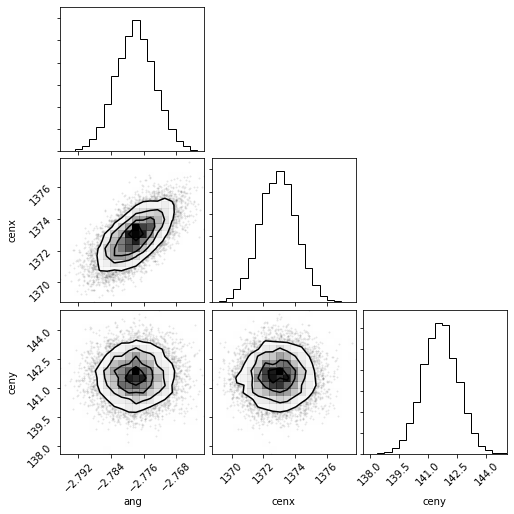

In [113]:
tm.plot_corner(BB)

In [95]:
CC = rot_om2det(0.85, 1347, 141.5, xOM, yOM)

In [114]:
flat_samples = BB.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)

In [115]:
ang, xanch, yanch

(-2.7780782152783248, 1372.9259499715, 141.60786859007277)

In [123]:
xOM1, yOM1, tp2 = tm.get_om_centroids(np.arange(2048))

In [144]:
CC = rot_om2det(ang, xanch, yanch, xOM, yOM)

(0, 256)

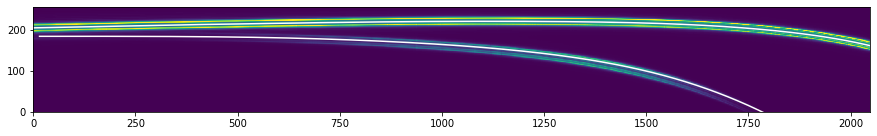

In [139]:
plt.figure(figsize=(15,3))
plt.imshow(clear/np.nanmax(clear, axis=0), origin='lower')
#plt.plot(aa[0]+500, aa[1], c='red')
plt.plot(CC[0], CC[1], c='white')
plt.plot(DD[0], DD[1], c='white')
#plt.plot(EE[0], EE[1], c='white')
plt.ylim(0, 256)

In [135]:
DD = tm.rot_om2det(ang, xanch, yanch, xOM1, yOM1)

In [140]:
EE = tm.get_data_centroids(stack, np.arange(2048))

In [142]:
FF = tm.do_emcee(xOM1, yOM1, EE[0], EE[1])

In [143]:
flat_samples = FF.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)
ang, xanch, yanch

(-1.0695248367384076, 850.6298044734453, 237.5258897605446)

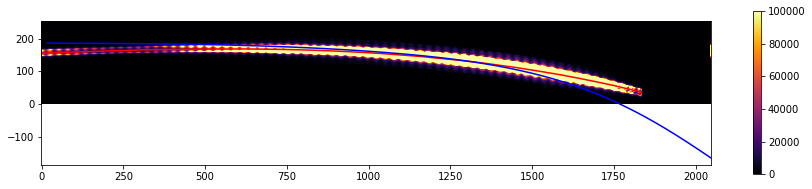

In [80]:
scidata[np.isnan(scidata)] = 0.
rebuilt[np.isnan(rebuilt)] = 0.

plt.figure(figsize=(15, 3))
plt.imshow(np.abs(rebuilt-scidata), origin='lower', vmax=1e5)
plt.plot(aa[0][:1832], aa[1][:1832], c='red')
plt.plot(xOM, yOM, c='blue')
plt.colorbar()

In [32]:
aa = tm.get_data_centroids(np.abs(rebuilt-scidata), atthesex=np.arange(2048))

In [68]:
bb

array([0.01046159, 0.04294047, 0.01522371, ..., 1.64667946, 1.50297184,
       4.19479432])

In [76]:
inds = []
bb = np.abs(np.diff(aa[1]))
for i in range(len(bb)):
    if i == 0:
        continue
    if bb[i] < 3*np.mean(bb):
        inds.append(i)

In [77]:
bbb = np.polyfit(aa[0][inds], aa[1][inds], 8)

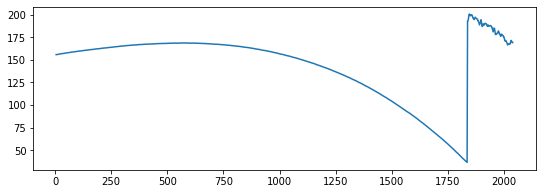

In [79]:
plt.plot(aa[0][inds], aa[1][inds])

In [65]:
aaaa = np.percentile(np.abs(np.diff(aa[1])), 50)
np.where(np.abs(np.diff(aa[1])) > 3*aaaa)

(array([1419, 1425, 1446, 1452, 1459, 1473, 1478, 1484, 1498, 1503, 1509,
        1515, 1522, 1528, 1533, 1539, 1552, 1557, 1563, 1569, 1575, 1581,
        1586, 1591, 1597, 1603, 1608, 1609, 1610, 1611, 1612, 1613, 1614,
        1615, 1616, 1617, 1618, 1619, 1623, 1629, 1632, 1633, 1634, 1635,
        1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646,
        1648, 1654, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666,
        1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1678, 1684, 1685,
        1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696,
        1697, 1698, 1699, 1700, 1701, 1702, 1708, 1710, 1711, 1712, 1713,
        1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724,
        1725, 1726, 1727, 1728, 1729, 1730, 1736, 1737, 1738, 1739, 1740,
        1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751,
        1752, 1753, 1754, 1755, 1756, 1757, 1758, 1762, 1763, 1764, 1765,
        1766, 1767, 1768, 1769, 1770, 

In [53]:
np.mean(np.diff(aa[1]))

0.002345375236150479

(1830, 1834)

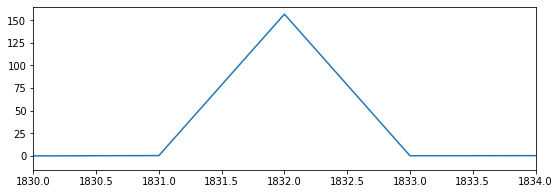

In [50]:
plt.plot(np.diff(aa[1]))
plt.xlim(1830, 1834)

In [40]:
xOM, yOM, tp2 = get_om_centroids(atthesex=np.linspace(0, 2047, 2048))  # OM

In [42]:
import sys
tppath = '/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/trace'
sys.path.insert(1, tppath)
import tracepol as tp

def get_om_centroids(atthesex=None):
    ''' Utility function to get order 1 trace profile centroids from the
    JWST NIRISS SOSS optics model.

    Parameters
    ----------
    atthesex : list of floats
        Pixel x values at which to evaluate the centroid position.

    Returns
    -------
    xOM : list of floats
        Optics model x centroid.
    yOM : list of floats
        Optics model y centroids.
    tp2 : list of floats
        trace polynomial coefficients.
    '''

    if atthesex is None:
        atthesex = np.linspace(0, 2047, 2048)

    # Derive the trace polynomials.
    tp2 = tp.get_tracepars(filename='%s/NIRISS_GR700_trace.csv' % tppath)

    # Evaluate the trace polynomials at the desired coordinates.
    w = tp.specpix_to_wavelength(atthesex, tp2, 2, frame='nat')[0]
    xOM, yOM, mas = tp.wavelength_to_pix(w, tp2, 2, frame='nat')

    return xOM, yOM[::-1], tp2